Project for the course in Microeconometrics, Summer 2019, Bonn University

---

## Replication of Jason M. Lindo, Nicholas J. Sanders & Philip Oreopoulos (2010) <a class="tocSkip"> 

In this notebook I replicate the main results from 

_Lindo, J. M., Sanders, N. J., & Oreopoulos, P. (2010). Ability, gender, and performance standards: Evidence from academic probation. American Economic Journal: Applied Economics, 2(2), 95-117._


The paper as well as all the materials needed for the replication can be accessed [here](https://www.aeaweb.org/articles?id=10.1257/app.2.2.95).

In [1]:
%matplotlib inline
import timeit
import numpy as np
import pandas as pd
import pandas.io.formats.style
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm_api
import matplotlib as plt
from IPython.display import HTML


In [2]:
# Import functions from auxiliary file
from auxiliary.auxiliary_predictions import *
from auxiliary.auxiliary_plots import *
from auxiliary.auxiliary_tables import *
from auxiliary.auxiliary_misc import *

# Overview 

Lindo et al. (2010) examine the effects of academic probation on student outcomes using data from Canada. Academic probation is a university policy that aims to improve the performance of the lowest scoring students. If a student's grade point average (GPA) drops below a certain threshold, the student is placed on academic probabtion. The probation status serves as a warning and does not entail immediate consequences, however, if students fail to improve their grades during the following year, they face the threat of being suspended from university. In a more general sense, academic probation may offer insights into how agents respond to negative incentives and the threat of punishment in a real world context with high stakes. 

To estimate the causal impact of being placed on probation, Lindo et al. (2010) apply a **regression discontinuity design (RDD)** to data retrieved from three campuses at a large Canadian university. The RDD is motivated by the idea that the students who score just above the threshold for being put on academic probation provide a good counterfactual to the 'treatment group' that scores just below the threshold and is put on academic probation. 

**Observed outcomes:**
* Drop-out rates
* Subsequent performance
* Graduation rates

**Covariates:**
* Gender
* High school performance
* Native language 
* Age at entry
* Credits attempted in 1st year
* Birthplace
* Campus

# Theoretical Background

The underlying framework used for the analysis is a model developed by Bénabou and Tirole (2000) which models agent's responses to a performance standard. While Bénabou and Tirole (2000) model a game between a principal and an agent, Lindo et al. (2010) focus only on an agent to relate the model to the example of academic probation. 

In the performance standard model, the agents face a choice between three options:
 1. **Option 1**: Incurs cost $c_1$ and grants benifit $V_1$ if sucessful.
 2. **Option 2**: Incurs cost $c_2$ and grants benifit $V_2$ if sucessful.
 3. **Neither** option: Incurs 0 cost and 0 benefit.
 
Option 1 has a lower cost and a lower benefit than option 2 such that:

\begin{equation}
    0 < c_1 < c_2 ,  0 < V_1 < V_2.
\end{equation}

Ability, denoted by $\theta$, translates to the probability of sucessfully completing either option. Assuming agents have perfect information about their ability, they solve the maximizing problem

\begin{equation}
max\{0, \theta V_1-c_1, \theta V_2-c_2\}.
\end{equation}
  
Let $\underline{\theta}$ be the ability level where the agent is indiffernt between neither and option two and let $\bar{\theta}$ be the ability level at which she is indifferent between option 1 and option 2. Assuming that

\begin{equation}
\underline{\theta} \equiv \frac{c_1}{V_1} < \bar{\theta} \equiv \frac{c_2-c_1}{V_2-V1} < 1
\end{equation}

ensures that both options are optimal for at least some $\theta$.

It can be shown that 
* the lowest ability types ($\theta < \underline{\theta}$) choose neither option,
* the highest ability types ($\bar{\theta} < \theta$) choose the difficult option,
* the individuals in between the high and low type $\underline{\theta}< \theta < \bar{\theta} $) choose the easier option.

If the principal now removes option 1 or makes choosing this option much more costly, then the agent will choose option 2 if and only if

\begin{equation}
\theta \ge \frac{c_2}{V_2} \equiv \theta^*
\end{equation}


and choose neither option otherwise. The agents who would have chosen option 1 now split according to ability. Agents with high ability (specifically those with $\theta \in [\theta^*,\bar{\theta}]$) work harder thereby choosing option 2 while low ability types (those with $\theta \in [\underline{\theta}, \theta^*]$) do not persue option 2 (& thus choose neither option).

In the context of academic probation, students face a similar decision problem and set of options. Students whose GPA is just above the probation cutoff face the full set of options for the next year:

1. **Option 1**: Return to school and exhibit low effort and achieving a low GPA
2. **Option 2**: Return to school and exhibit high effort with the intent of achieving a high GPA
3. **Neither** option: Drop out of university

The students who score below the probation cutoff face a restricted set of options, as the univsersity administration essentially eliminates option 1 by suspending students if they do not improve their grades. 

Lindo et al. (2010) formulate three testable implications of this theoretical framework: 

  * _Forbidding option 1 will **increase the overall probability of students dropping out**._
  * _Forbidding option 1 will **increase the performance of those who return**._
  * _Forbidding option 1 will cause **relatively low-ability students to drop out** and **relatively high-ability students to return and work harder**._

# Causal Graphs

wip

# Study replication

In [3]:
# Loading the data
data = pd.read_stata('data/data_for_analysis.dta')
data.shape

(44362, 86)

## Data & Descriptive Statistics
Overview of all variables in the provided dataset:

In [4]:
columnlist = data.columns
print(columnlist)

Index(['credits1', 'credits2', 'credits_earned1', 'credits_earned2',
       'session1', 'winter_ac_standing', 'GPA_year1', 'GPA_year2',
       'CGPA_year1', 'CGPA_year2', 'totcredits_year1', 'totcredits_year2',
       'goodstanding_year1', 'goodstanding_year2', 'winter_ac_stand_year1',
       'winter_ac_stand_year2', 'fallreg_year1', 'fallreg_year2',
       'act_fallreg_year1', 'act_fallreg_year2', 'summerreg_year1',
       'summerreg_year2', 'sex', 'mtongue', 'identifier', 'age_at_entry',
       'bpl_north_america', 'bpl_asia', 'canadian', 'bpl_other', 'firstyear',
       'yearstodegree', 'gradin4', 'gradin5', 'gradin6', 'gradin4orcont',
       'cumcredits1', 'cumcredits2', 'prog_science', 'prog_socsci_bus',
       'prog_socscihum', 'prog_unknown', 'english', 'noenglish', 'french',
       'other_lang', 'female', 'male', 'gpacutoff', 'dist_from_cut',
       'year2_dist_from_cut', 'CGPA_final', 'nextGPA', 'nextCGPA',
       'probation_year1', 'probation_year2', 'probation_summer1',
    

In [5]:
# Add constant to data to use in regressions later.
data.loc[:,'const'] = 1

In [6]:
# Variable scoring above cutoff in next term
for i in data.index:
    if data.loc[i,'nextGPA'] >= 0:
        data.loc[i,'nextGPA_above_cutoff'] = 1
    elif np.isnan(data.loc[i,'nextGPA']):
        data.loc[i,'nextGPA_above_cutoff'] = np.NaN
    else:
        data.loc[i,'nextGPA_above_cutoff'] = 0

C:\Users\arohanui\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# Variable for improving GPA in the next term
for i in data.index:
    if data.loc[i,'nextGPA'] > data.loc[i,'dist_from_cut']:
        data.loc[i,'improved_GPA'] = 1
    else:
        data.loc[i,'improved_GPA'] = 0

### Data Restriction & Preparation

Lindo et al. (2010) filter the data to meet the following requirements:
* Students entered university before the year 2004 ( to ensure they can be observed over a 2-year period)
* Students are between 17 and 21 years of age at time of entry
* Distance from cutoff is maximally 0.6

In the following section I prepare the dataset to meet these requirements:

In [8]:
data.firstyear.unique()

array([2002, 2001, 2000, 2003, 1996, 1998, 1997, 1999], dtype=int64)

In [9]:
data.age_at_entry.unique()

array([19., 18., 20., 17., 21.])

The dataset provided for replication is already filtered by age and year of university entrance. The distance from cutoff still spans from  values of -1.6 to 2.8 as can be seen below. I thus filter the data further to receive the sample used in the study.

(array([ 463.,  379.,  515.,  775., 1087., 1484., 1951., 2314., 2945.,
       3383., 3783., 4045., 4199., 3957., 3643., 3146., 2634., 2172.,
       1343.,  144.]), array([-1.6       , -1.38      , -1.1600001 , -0.94000006, -0.72      ,
       -0.5       , -0.28000003, -0.06000003,  0.15999997,  0.37999997,
        0.59999996,  0.81999993,  1.04      ,  1.26      ,  1.48      ,
        1.6999999 ,  1.92      ,  2.1399999 ,  2.36      ,  2.58      ,
        2.8       ], dtype=float32), <a list of 20 Patch objects>)


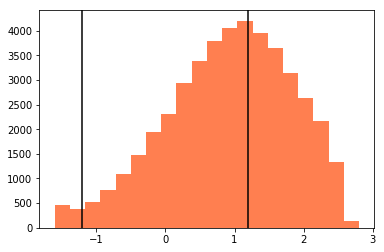

In [10]:
# Distribution of values for distance from cutoff.
plt.pyplot.axvline(x=-1.2, color='k')
plt.pyplot.axvline(x= 1.2, color='k')
print(plt.pyplot.hist(data['dist_from_cut'], color = "coral", bins=20))

In [11]:
# Reduce sample to students within 1.2 points from cutoff.
sample12 = data[abs(data['dist_from_cut']) < 1.2] 
sample12.reset_index(inplace=True)
print("A sample of students within 1.2 points from the cuttoff encompasses", sample12.shape[0], "observations.")

A sample of students within 1.2 points from the cuttoff encompasses 25389 observations.


In [12]:
# Reduce sample to students within 0.6 points from cutoff.
sample06 = data[abs(data['dist_from_cut']) < 0.6]  
sample06.reset_index(inplace=True)
print("The final sample includes", sample06.shape[0], "observations.")

The final sample includes 12530 observations.


### Summary Statistics and Table 1

In [13]:
table_1_var = sample06[['hsgrade_pct','totcredits_year1', 'age_at_entry','male', 'english', 'bpl_north_america', 
             'loc_campus1','loc_campus2', 'loc_campus3',
             'dist_from_cut', 'probation_year1', 'probation_ever', 'left_school', 'year2_dist_from_cut',
             'suspended_ever', 'gradin4', 'gradin5', 'gradin6']]

In [14]:
table1 = pd.DataFrame()
table1['Mean'] = table_1_var.mean()
table1['Standard Deviation'] = table_1_var.std()
#table1 = table1.astype(float).round(2)
table1['Description'] = ["High School Grade Percentile", "Credits attempted first year", "Age at entry",
                         "Male", "English is first language", "Born in North America", 
                         "At Campus 1", "At Campus 2", "At Campus 3",
                         "Distance from cutoff in first year", "On probation after first year", " Ever on acad. probation",
                         "Left uni after 1st evaluation", "Distance from cutoff at next evaluation", "Ever suspended",
                         "Graduated by year  4", "Graduated by year  5", "Graduated by year  6"]
table1.loc[0:9,'Type'] = "Characteristics"
table1.loc[9:,'Type'] = "Outcomes"
table1

,Mean,Standard Deviation,Description,Type
hsgrade_pct,33.332085,23.288502,High School Grade Percentile,Characteristics
totcredits_year1,4.426975,0.530186,Credits attempted first year,Characteristics
age_at_entry,18.718756,0.735240,Age at entry,Characteristics
male,0.375180,0.484199,Male,Characteristics
english,0.718755,0.449625,English is first language,Characteristics
bpl_north_america,0.870231,0.336071,Born in North America,Characteristics
loc_campus1,0.478132,0.499548,At Campus 1,Characteristics
loc_campus2,0.209497,0.406989,At Campus 2,Characteristics
loc_campus3,0.312370,0.463482,At Campus 3,Characteristics
dist_from_cut,0.111093,0.325851,Distance from cutoff in first year,Outcomes


## Empirical Strategy

The author examine the impact of being put on probation after the first year in university. The probation status after the first year is a deterministic funtion of student's GPA, formally

\begin{equation}
PROB^{year1}_{IC} = 1(GPANORM^{year1}_{IC} < 0),
\end{equation}

where $PROB^{year1}_{IC}$ represents the probation status of student $i$ at campus $c$ and $GPANORM^{year1}_{IC}$ is the distance between student i's first year GPA and the probationary cutoff at their respective campus. 

Applying the regression dicontunity design, the treatment effect for students near the threshold is obtained by comparing the outcomes of students just below the threshold to those just above the threshold.

The following equation can be used to estimate the effects of academic probation on subsequent student outcomes:

\begin{equation}
Y_{ic} = m(GPANORM_{ic}^{year1}) + \delta1(GPANORM_{ic}^{year1}<0) + u_{ic} 
\end{equation}

* $Y_{ic}$ denotes the outcome for student $i$ at campus $c$, 
* $m(GPANORM_{ic}^{year1})$ is a continuous function of students's tandarized first year GPAs,
* $1(GPANORM_{ic}^{year1}<0)$ is an indicator function equal to 1 if the student's GPA is below the probation cutoff
* $u_{ic} $ is the error term
* $\delta$ is the coeffcient for the estimated impact of being placed on academic probation after the first year

For the regression analysis, Lindo et al. (2010) extend the above equation by an interaction term and a constant:

\begin{equation}
Y_{ic} = \alpha + \delta1(GPANORM_{ic}^{year1}<0) + \beta(GPANORM_{ic}^{year1}) 
                + \gamma(GPANORM_{ic}^{year1})x 1(GPANORM_{ic}^{year1}<0) + u_{ic} 
\end{equation}


## Replication of Results

In [15]:
sample_treat = sample12[sample12['dist_from_cut'] < 0].copy()
sample_untreat = sample12[sample12['dist_from_cut'] >= 0].copy()
sample12 = pd.concat([sample_untreat, sample_treat])
#sample12.reset_index(inplace=True)
#sample12 = sample12.sort_values(by=['dist_from_cut'])

### Tests of the Validity of the RD Approach

The core motivation in the application of RD approaches is the idea, that the variation in treatment near the cutoff is random if subjects are unable to control the selection into treatment (Lee & Lemieux, 2010). This condition, if fulfilled, means the RDD is able to closely emulate a randomized experiment and allows researchers to identify the effects of treatment. 

For evaluating the effects of academic probation on subsequent student outcomes, the RDD is thus a valid approach only if students are not able to precisely manipulate whether they score above or below the cutoff. Lindo et al. (2010) offer multiple arguments to adress concerns about nonrandom sorting: 

1. The study focuses on **first year students**, assuming this group of students is likely to be less familiar with the probation policy on campus. To verify their conjecture, the authors also conducted a survey in an introductory economics course which revealed that around 50 % of students were unsure of the probation cutoff at their campus. They also claim that this analysis showed no relationship between knowledge of probation cutoffs and student's grades. 


2. The authors also point out that most first year courses span the entire year and most of the evaluation takes place at the end of the term which would make it difficult for students to purposely aim for performances slightly above the cutoff for academic probation.


3. Finally, and most importantly, the implication of local randomization is testable. If nonrandom sorting were to be a problem, there should be a **discontinuity** in the distribution of grades at the cutoff with a disproportionate number of students scoring just above the cutoff. Figure 1 and table 2 show the (replicated) results of tests for such discontinuities.

#### Figure 1 | Distribution of Student Grades Relative to their Cutoff

The data (containing all observations within 1.2 GPA points from the cutoff) is sorted into bins of size 0.1. The bins contain their lower limit but not their upper limit. To replicate the result fron Lindo et al., I calculate the frequency of each bin and then run a local linear regression with a bandwidth of 0.6 on each bin. Figure 1 shows the bins and the predicted frequency for each bin. The results show that the **distribution of grades is continuous around the cutoff**, suggesting that we can assume local randomization.

In [16]:
#Calculate frequency of each bin.
bin_frequency_fig1 = calculate_bin_frequency(data=sample12, bins="dist_from_cut_med10")

# Calculate predicted frequency of each bin with local linear regression.
predictions_fig1 = create_bin_frequency_predictions(data=bin_frequency_fig1, 
                                                    steps=bin_frequency_fig1.bins.unique().round(4), 
                                                    bandwidth=0.6
                                                   )

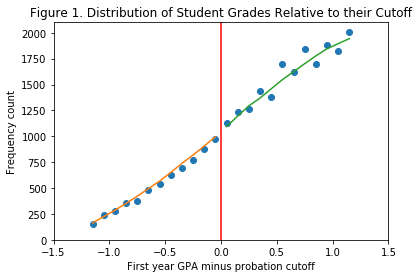

In [17]:
plot_bin_frequency_RDD(bin_frequency=bin_frequency_fig1, 
                       bins=bin_frequency_fig1.bins.unique().round(4), 
                       predictions=predictions_fig1
                      )

#### Table 2 - Estimated Discontinuities in observable characteristics 

In [18]:
# Reduce sample to bandwidth of 0.6 for the next steps.
sample06 = sample12[abs(sample12['dist_from_cut']) < 0.6]  
sample06.shape

(12530, 90)

Table 2 shows the results of local linear regession (using a bandwidth of 0.6) for a range of observable characteristics that are related to student outcomes. Significant discontinuities would indicate that students with certain characterstics might be able to manipulate their grades to score above the probation cutoff. Table 2 shows that the coefficient for scoring below the cutoff is insignificant at the 10% level for all covariates. These estimates support the validity of the RD approach. 

In [19]:
# Define covariates and regressors.
covariates = ('hsgrade_pct','totcredits_year1', 'age_at_entry','male', 'english', 'bpl_north_america', 
              'loc_campus1','loc_campus2')
regressors = ['const','gpalscutoff','gpaXgpalscutoff','gpaXgpagrcutoff']


In [20]:
# Generate table 2 (code imported from auxiliary file)
table2 = estimate_RDD_multiple_outcomes(data=sample06, outcomes=covariates, regressors=regressors)
# Mark significant p-values (at 5% level) red & display table.
table2.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
outcomes,,,,,,,
hsgrade_pct,0.45,0.72,1.259,30.991,0,0.745,12530
totcredits_year1,0.024,0.749,0.076,4.386,0,0.046,12530
age_at_entry,0.015,0.641,0.032,18.719,0,0.021,12530
male,0,0.989,0.024,0.374,0,0.012,12530
english,-0.037,0.124,0.024,0.729,0,0.015,12530
bpl_north_america,0.017,0.173,0.013,0.864,0,0.008,12530
loc_campus1,0.012,0.724,0.034,0.444,0,0.022,12530
loc_campus2,-0.01,0.719,0.027,0.217,0,0.018,12530


<span style="color:orange">_NOTE:</span> My results for 'Male' and 'Age at entry' are switched compared to the table presented in Lindo et al. (2010). Since the results are identical otherwise, I assume this difference stems from an error in the table formatting of the published paper._

### First year GPAs and Academic Probation

Figure 2 and the Table 3 show the estimated discontinuity in probation status. Figure 2 and the first part of Table 3 show th estimated discontinuity for the probation status after the _first year_. The second part of Table 3 presents the results for the estimated effects of scoring below the cutoff on the probability of _ever_ being placed on academic probation.

Figure 2 and part 1 of table 3 veryfying that the discontiuity at the cutoff is **sharp**, i.e. all students whose GPA falls below the cutoff are placed on probation. For students below the cutoff the probability of being placed on probation is 1, for students above the cutoff it is 0.

It should be noted that the estimated discontinuity at the cutoff is only approximately equal to 1 for all of the different subgroups, as the results in part 1 of table 3 show. The authors attribute this fact to adiministrative errors in the data reportage. 

#### Figure 2 - Porbation Status at the End of First Year

In [21]:
predictions_fig2 = create_predictions(data=sample12, outcome = 'probation_year1', regressors=regressors, bandwidth=0.6)

Text(0,0.5,'Probation Status')

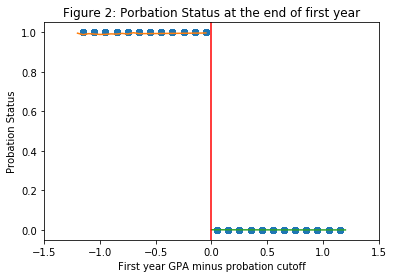

In [22]:
plt.pyplot.xlim(-1.5,1.5,0.1)
plt.pyplot.plot(sample12['dist_from_cut_med10'], sample12['gpalscutoff'], 'o')
plot_RDD_curve(df = predictions_fig2, running_variable="dist_from_cut", outcome="prediction", cutoff=0)
plt.pyplot.axvline(x=0, color='r')
plt.pyplot.title('Figure 2: Porbation Status at the end of first year')
plt.pyplot.xlabel('First year GPA minus probation cutoff')
plt.pyplot.ylabel('Probation Status')

#### Table 3 - Estimated Discontinuity in Probabtion Status

To estimate the discontunuity in probation status, the authors again use a bandwidth of 0.6 from the cutoff. In addition to the whole sample this condition applies to, they also estimate the discontinuities for certain subgroups in the sample:

* **high school grades below** and **above the median** (here, median refers to the median of the entire dataset (median: _50_) and not the median of the subset of students with a GPA within 0.6 grade points of teh probation cutoff (the median for this set would be _28_))
* **male** and **female** students
* **english** native speakers and students with a different native language (**nonenglish**) 

In [23]:
#Create dictionary containg all the subsets we want to analyse.
groups_dict_keys = ['All', 'HS Grades < median', 'HS Grades > median', 'Male', 'Female', 'Native English', 'Nonnative English']
groups_dict_columns = ['const', 'lowHS', 'highHS', 'male', 'female', 'english', 'noenglish']
groups_dict_06=create_groups_dict(data=sample06, 
                                  keys=groups_dict_keys, 
                                  columns=groups_dict_columns
                                 )

**Table 3 | Part 1 - Estimated Discontinuity in Probation Status for Year 1**


In [24]:
# Import function for RDD analysis from auxiliary file.
table3_1 = estimate_RDD_multiple_datasets(dictionary=groups_dict_06, keys=groups_dict_keys, outcome='probation_year1', regressors= regressors)
table3_1.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.994,0,0.002,0.001,0.157,0.001,12530
HS Grades < median,0.995,0,0.002,0.001,0.183,0.001,9473
HS Grades > median,0.99,0,0.006,0.001,0.317,0.001,3057
Male,0.99,0,0.005,0.001,0.319,0.001,4701
Female,0.996,0,0.002,0.001,0.179,0.001,7829
Native English,0.993,0,0.002,0.001,0.16,0.001,9006
Nonnative English,0.997,0,0.003,0,0,0,3524


**Table 3 | Part 2 - Estimated Discontinuity in Probabtion Status Ever**

Part 2 of Table 3 presents the estimated effect of scoring below the cutoff in the first year for _ever_ being placed on probation. The results show that even for those who score slightly above the probation cutoff in year 1, 33 % are placed on probabtion at some other point in time during their studies. 

For the different subgroups of students this value varies from 29% (for students with high school grades above the median) up to 36.7% (for the group of males). These results already indicate that we can expect heterogeneities in the way different students react to being placed on academic probation.

The fact that it is not unlikely for low performing students just slightly above the cutoff to fall below it in later terms also underlines these student's fitness as a control group for the purpose of the analysis. Lindo et al. (2010) argue that the controls can be thought of as receiving a much weaker form of treatment than the group that is placed on probation, as scoring just above the cutoff in year 1 does not save students from falling below the cutoff and being placed on probation in subsequent terms. 

In [25]:
# Import function for RDD analysis from auxiliary file.
table3_1 = estimate_RDD_multiple_datasets(dictionary=groups_dict_06, keys=groups_dict_keys, outcome='probation_ever', regressors= regressors)
table3_1.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.665,0,0.014,0.33,0,0.014,12530
HS Grades < median,0.653,0,0.014,0.343,0,0.014,9473
HS Grades > median,0.705,0,0.023,0.286,0,0.022,3057
Male,0.625,0,0.016,0.366,0,0.015,4701
Female,0.69,0,0.017,0.308,0,0.017,7829
Native English,0.677,0,0.016,0.317,0,0.016,9006
Nonnative English,0.635,0,0.023,0.362,0,0.022,3524


### The Immediate Response to Academic Probation 

Students who have been placed on academic probation enter their next term at univsersity with the threat of suspension in case they fail to improve their grades. Recalling the theoretical framework presented in prior sections, students face the following set of options after each term:

1. **Option 1**: Return to school, exhibit low effort and achieving a low GPA,
2. **Option 2**: Return to school, exhibit high effort with the intent of achieving a high GPA,
3. **Neither** option: Drop out of university.

Students on probabtion face a different set of choices than the students that were not placed on probabtion as the threat of suspension essentially eliminates option 1. Of course students could enter the next term, exhibit low effort and receive low grades but this would result in suspension. Since both option 1 and option 3 result in the student not continuing school (at least for a certain period of time), students who are not willing to exhibit high effort (and thus will be suspended) are much better off dropping out and saving themselves the cost of exhibiting low effort.

#### Table 4 - Estimated Effect on the Decision to Leave after the First Evaluation

Table 4 shows the estimated effect of dropping below the cutoff on the drop out rates after the first year. The results indicate that being placed on probation increases the probability of leaving university by 1.8 percentage points which is 44 % of the control mean.

In [26]:
# Import function for RDD analysis from auxiliary file.
table4 = estimate_RDD_multiple_datasets(dictionary=groups_dict_06, keys=groups_dict_keys, outcome='left_school', regressors= regressors)
table4.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.018,0.01,0.007,0.041,0,0.004,12530
HS Grades < median,0.013,0.107,0.008,0.045,0,0.005,9473
HS Grades > median,0.032,0.058,0.017,0.026,0,0.007,3057
Male,0.037,0.014,0.015,0.038,0,0.007,4701
Female,0.006,0.53,0.009,0.043,0,0.004,7829
Native English,0.028,0.003,0.01,0.047,0,0.005,9006
Nonnative English,-0.004,0.713,0.011,0.025,0,0.007,3524


#### Figure 3 - Stratified Results for Voluntarily Leaving School at the End of the First year

In [27]:
groups_dict_12=create_groups_dict(data=sample12, keys=groups_dict_keys, columns=groups_dict_columns)

In [28]:
predictions_groups_dict = create_fig3_predictions(groups_dict = groups_dict_12, regressors=regressors, bandwidth=0.6)

Text(0.5,1,'Nonnative English')

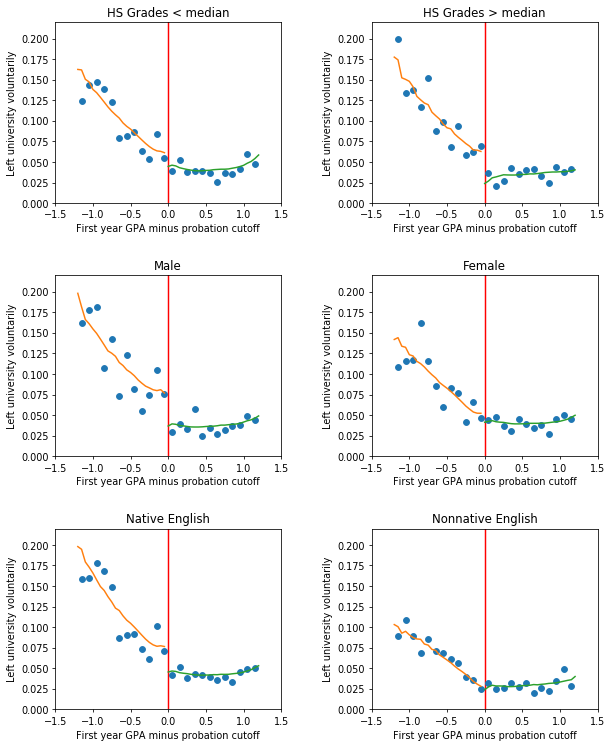

In [29]:
figure_3 = plot_figure3(inputs_dict = groups_dict_12,  outputs_dict=predictions_groups_dict, keys=groups_dict_keys)
figure_3

### The Impact on Subsequent Performance

#### Table 5 - Estimated Discontinuites in subsequent GPA | Part A - Next Term GPA

In [31]:
#### Table 5 / Part A
table5 = estimate_RDD_multiple_datasets(dictionary=groups_dict_06, keys=groups_dict_keys, outcome='nextGPA', regressors= regressors)
table5.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.233,0,0.026,0.312,0,0.018,11258
HS Grades < median,0.247,0,0.029,0.275,0,0.02,8457
HS Grades > median,0.179,0.028,0.081,0.443,0,0.044,2801
Male,0.207,0,0.044,0.281,0,0.027,4166
Female,0.246,0,0.036,0.33,0,0.024,7092
Native English,0.229,0,0.036,0.309,0,0.02,8012
Nonnative English,0.24,0,0.055,0.318,0,0.035,3246


#### Table 5 - Estimated Discontinuites in subsequent GPA | Part B - Probability of improving GPA in next term

Panel B of table 5 shows the probability of scoring above the cutoff in the next term. The next term can refer to the next acamdeic year but also summer classes that only some students enroll for.

In [33]:
table5 = estimate_RDD_multiple_datasets(dictionary=groups_dict_06, keys=groups_dict_keys, outcome='nextGPA_above_cutoff', regressors= regressors)
table5.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.099,0,0.014,0.693,0,0.009,11258
HS Grades < median,0.109,0,0.017,0.68,0,0.011,8457
HS Grades > median,0.061,0.073,0.034,0.737,0,0.02,2801
Male,0.075,0.001,0.022,0.68,0,0.013,4166
Female,0.111,0,0.022,0.7,0,0.014,7092
Native English,0.112,0,0.02,0.691,0,0.011,8012
Nonnative English,0.07,0.004,0.024,0.697,0,0.019,3246


#### Figure 4 - GPA in the next enrolled term

In [34]:
predictions_fig4 = create_predictions(data=sample12, outcome = 'year2_dist_from_cut', regressors=regressors, bandwidth=0.6)

Text(0.5,1,'Figure 4 - GPA in the next enrolled term')

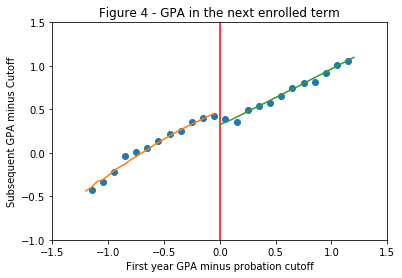

In [35]:
plt.pyplot.xlim(-1.5,1.5,0.1)
plt.pyplot.ylim(-1,1.5,0.1)
plt.pyplot.axvline(x=0, color='r')
plt.pyplot.xlabel('First year GPA minus probation cutoff')
plt.pyplot.ylabel('Subsequent GPA minus Cutoff')
plt.pyplot.plot(sample12.year2_dist_from_cut.groupby(sample12['dist_from_cut_med10']).mean(), 'o')
plot_RDD_curve(df = predictions_fig4, running_variable="dist_from_cut", outcome="prediction", cutoff=0)
plt.pyplot.title("Figure 4 - GPA in the next enrolled term")

### The Impacts on Graduation

#### Figure 5 - Graduation Rates

In [36]:
predictions_fig5_gradin4 = create_predictions(data=sample12, outcome = 'gradin4', regressors=regressors, bandwidth=0.6)
predictions_fig5_gradin5 = create_predictions(data=sample12, outcome = 'gradin5', regressors=regressors, bandwidth=0.6)
predictions_fig5_gradin6 = create_predictions(data=sample12, outcome = 'gradin6', regressors=regressors, bandwidth=0.6)

Text(0.5,1,'Figure 5 - Graduation Rates')

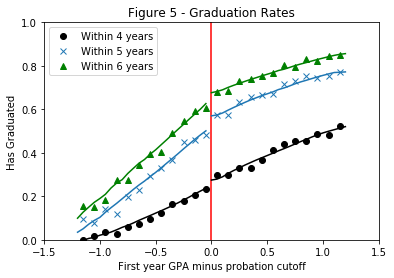

In [37]:
plt.pyplot.xlim(-1.5,1.5,0.1)
plt.pyplot.ylim(0,1,0.1)
plt.pyplot.axvline(x=0, color='r')
plt.pyplot.xlabel('First year GPA minus probation cutoff')
plt.pyplot.ylabel('Has Graduated')

plt.pyplot.plot(sample12.gradin4.groupby(sample12['dist_from_cut_med10']).mean(), 'o', color='k', label= 'Within 4 years')
plot_RDD_curve_colored(df = predictions_fig5_gradin4, running_variable="dist_from_cut", outcome="prediction", cutoff=0, color = 'k')

plt.pyplot.plot(sample12.gradin5.groupby(sample12['dist_from_cut_med10']).mean(), 'x', color ='C0', label= 'Within 5 years')
plot_RDD_curve_colored(df = predictions_fig5_gradin5, running_variable="dist_from_cut", outcome="prediction", cutoff=0, color = 'C0' )

plt.pyplot.plot(sample12.gradin6.groupby(sample12['dist_from_cut_med10']).mean(), '^', color='g', label= 'Within 6 years')
plot_RDD_curve_colored(df = predictions_fig5_gradin6, running_variable="dist_from_cut", outcome="prediction", cutoff=0, color ='g')


plt.pyplot.legend()
plt.pyplot.title("Figure 5 - Graduation Rates")

#### Table 6 - Estimated Effects on Graduation

In [38]:
table6_1 = estimate_RDD_multiple_datasets(dictionary=groups_dict_06, keys=groups_dict_keys, outcome='gradin4', regressors= regressors)
table6_1.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,-0.02,0.249,0.017,0.272,0,0.011,8821
HS Grades < median,-0.019,0.331,0.019,0.265,0,0.015,6826
HS Grades > median,-0.02,0.672,0.048,0.296,0,0.034,1995
Male,-0.045,0.113,0.028,0.214,0,0.02,3373
Female,-0.004,0.891,0.027,0.307,0,0.012,5448
Native English,-0.047,0.018,0.02,0.277,0,0.012,6406
Nonnative English,0.048,0.161,0.034,0.258,0,0.023,2415


In [39]:
table6_2 = estimate_RDD_multiple_datasets(dictionary=groups_dict_06, keys=groups_dict_keys, outcome='gradin5', regressors= regressors)
table6_2.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,-0.044,0.095,0.026,0.566,0,0.018,7293
HS Grades < median,-0.025,0.415,0.03,0.55,0,0.023,5610
HS Grades > median,-0.113,0.02,0.049,0.62,0,0.028,1683
Male,-0.055,0.175,0.04,0.503,0,0.03,2799
Female,-0.039,0.181,0.03,0.606,0,0.018,4494
Native English,-0.065,0.02,0.028,0.552,0,0.018,5320
Nonnative English,0.004,0.933,0.042,0.603,0,0.029,1973


In [40]:
table6_3 = estimate_RDD_multiple_datasets(dictionary=groups_dict_06, keys=groups_dict_keys, outcome='gradin6', regressors= regressors)
table6_3.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,-0.024,0.316,0.024,0.674,0,0.018,6005
HS Grades < median,0.007,0.813,0.028,0.652,0,0.022,4649
HS Grades > median,-0.145,0.006,0.053,0.76,0,0.022,1356
Male,-0.081,0.052,0.042,0.646,0,0.03,2313
Female,0.008,0.8,0.031,0.693,0,0.019,3692
Native English,-0.041,0.162,0.03,0.657,0,0.016,4417
Nonnative English,0.007,0.882,0.045,0.726,0,0.032,1588


---

# Robustness Checks (upcoming)

In [41]:
# Changing the style of plots for this part to visually distinguish from the replication
plt.style.use('ggplot')

## Adjusting specifications

Valdidity checks: Different bin sizes

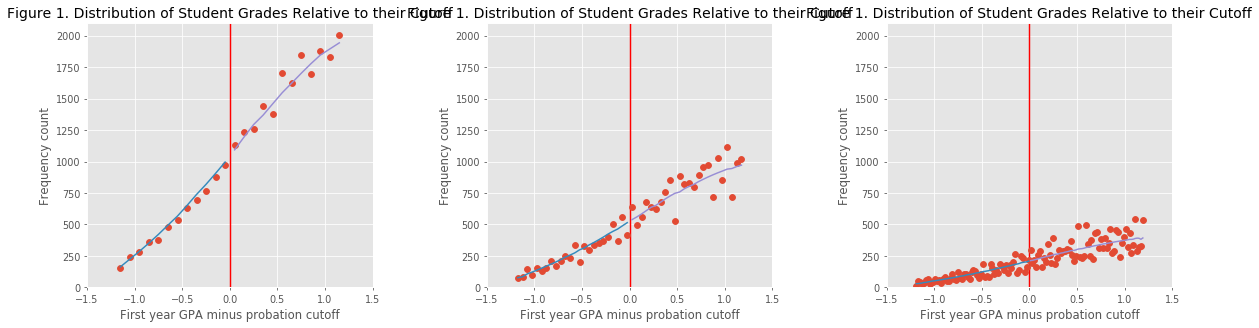

In [42]:
bin_sizes = ["dist_from_cut_med10", "dist_from_cut_med05", "dist_from_cut_med025"]

plt.pyplot.figure(figsize=(20, 5), dpi=70, facecolor='w', edgecolor='k')
plt.pyplot.subplots_adjust(wspace=0.4, hspace=0.4)

for idx, bin_size in enumerate(bin_sizes):
    plt.pyplot.subplot(1, 3, idx + 1)
    
    
    bin_frequency_fig1 = calculate_bin_frequency(data=sample12, bins=bin_size)

    # Calculate predicted frequency of each bin with local linear regression.
    predictions_fig1 = create_bin_frequency_predictions(data=bin_frequency_fig1, 
                                                        steps=bin_frequency_fig1.bins.unique().round(4), 
                                                        bandwidth=0.6
                                                       )

    plot_bin_frequency_RDD(bin_frequency=bin_frequency_fig1, 
                           bins=bin_frequency_fig1.bins.unique().round(4), 
                           predictions=predictions_fig1
                          )

## Placebo 

To test the robustness of the results from the paper presented in my replication, I implement a placebo regression. This means I define a new fictional cutoff point and run the regressions from the previous parts based on the distances from the fictional cutoff. Artificially increasing the probation thresholdin our data means that in the new regression, some students will be counted towards the treatment group even though in reality, they were not put on probation since they scored above the actual cutoff. 

### Placebo regression for a cutoff that is _0.3 GPA points higher_ than the actual probation cutoff
I first increase the threshold point by 0.3 GPA points i.e. if the probation cutoff was at a GPA of 1.7 before, it is now at 2.0

In [43]:
variables = ['const', 'dist_from_cut','gpalscutoff', 'gpaXgpalscutoff', 'gpaXgpagrcutoff', 
             'lowHS', 'highHS', 'male', 'female', 'english', 'noenglish', 'left_school']

In [44]:
placebo1_data = gen_placebo_data(data=data, cutoff_deviation=(0.3))

In [45]:
# Reduce dataset to range 1.2 as we used before
placebo1_data12 = placebo1_data[abs(placebo1_data['dist_from_cut']) < 1.2].copy()

# Bin data according to new distances from cutoff
bins_labels = np.arange(-1.15,1.25,0.1)
placebo1_data12['dist_from_cut_med10'] = pd.cut(x=placebo1_data12['dist_from_cut'],bins=24,labels=bins_labels, right=False)

# Create another dataset with a maximum distance of 0.6 from the cutoff
placebo1_data06 = placebo1_data12[abs(placebo1_data12['dist_from_cut']) < 0.6].copy()

In [46]:
groups_dict_06_placebo1=create_groups_dict(data=placebo1_data06, 
                                  keys=groups_dict_keys, 
                                  columns=groups_dict_columns
                                 )

In [47]:
# Import function for RDD analysis from auxiliary file.
table4_placebo1 = estimate_RDD_multiple_datasets(dictionary=groups_dict_06_placebo1, keys=groups_dict_keys, outcome='left_school', regressors= regressors)
table4_placebo1.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,-0.009,0.158,0.006,0.04,0,0.004,16151
HS Grades < median,-0.002,0.83,0.008,0.038,0,0.005,11154
HS Grades > median,-0.027,0.019,0.011,0.044,0,0.007,4997
Male,-0.022,0.043,0.011,0.041,0,0.008,5988
Female,-0,0.993,0.008,0.039,0,0.006,10163
Native English,-0.01,0.157,0.007,0.044,0,0.005,11726
Nonnative English,-0.005,0.672,0.011,0.029,0,0.006,4425


In [48]:
groups_dict_12_placebo1=create_groups_dict(data=placebo1_data12, 
                                  keys=groups_dict_keys, 
                                  columns=groups_dict_columns
                                 )

Text(0.5,1,'Nonnative English')

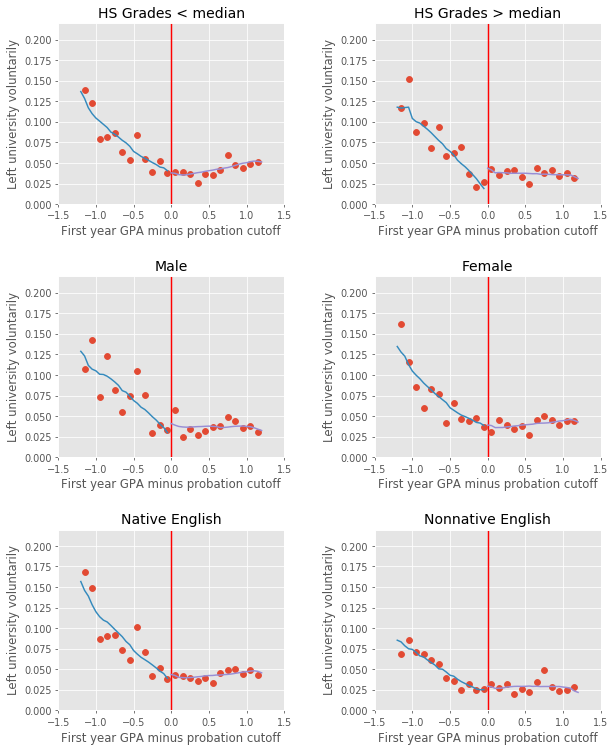

In [49]:
predictions_groups_dict_placebo1 = create_fig3_predictions(groups_dict = groups_dict_12_placebo1, 
                                                          regressors=regressors, 
                                                          bandwidth=0.6
                                                         )

figure_3_placebo1 = plot_figure3(inputs_dict = groups_dict_12_placebo1,  outputs_dict=predictions_groups_dict_placebo1, keys=groups_dict_keys)
figure_3_placebo1

### Placebo regression for a cutoff that is _0.6 GPA points higher_ than the actual probation cutoff
I first increase the threshold point by 0.6 GPA points i.e. if the probation cutoff was at a GPA of 1.7 before, it is now at 2.3.

In [50]:
variables = ['const', 'dist_from_cut','gpalscutoff', 'gpaXgpalscutoff', 'gpaXgpagrcutoff', 
             'lowHS', 'highHS', 'male', 'female', 'english', 'noenglish', 'left_school']

In [51]:
placebo1_data = gen_placebo_data(data=data, cutoff_deviation=(0.6))

In [52]:
# Reduce dataset to range 1.2 as we used before
placebo1_data12 = placebo1_data[abs(placebo1_data['dist_from_cut']) < 1.2].copy()

# Bin data according to new distances from cutoff
bins_labels = np.arange(-1.15,1.25,0.1)
placebo1_data12['dist_from_cut_med10'] = pd.cut(x=placebo1_data12['dist_from_cut'],bins=24,labels=bins_labels, right=False)

# Create another dataset with a maximum distance of 0.6 from the cutoff
placebo1_data06 = placebo1_data12[abs(placebo1_data12['dist_from_cut']) < 0.6].copy()

In [53]:
groups_dict_06_placebo1=create_groups_dict(data=placebo1_data06, 
                                  keys=groups_dict_keys, 
                                  columns=groups_dict_columns
                                 )

In [54]:
# Import function for RDD analysis from auxiliary file.
table4_placebo1 = estimate_RDD_multiple_datasets(dictionary=groups_dict_06_placebo1, keys=groups_dict_keys, outcome='left_school', regressors= regressors)
table4_placebo1.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.008,0.133,0.006,0.029,0,0.004,18794
HS Grades < median,0.011,0.121,0.007,0.025,0,0.005,11696
HS Grades > median,0.008,0.389,0.009,0.033,0,0.007,7098
Male,0.009,0.251,0.008,0.027,0,0.005,6917
Female,0.008,0.246,0.007,0.03,0,0.005,11877
Native English,0.007,0.306,0.007,0.032,0,0.005,13748
Nonnative English,0.013,0.114,0.008,0.021,0,0.005,5046


In [55]:
groups_dict_12_placebo1=create_groups_dict(data=placebo1_data12, 
                                  keys=groups_dict_keys, 
                                  columns=groups_dict_columns
                                 )

Text(0.5,1,'Nonnative English')

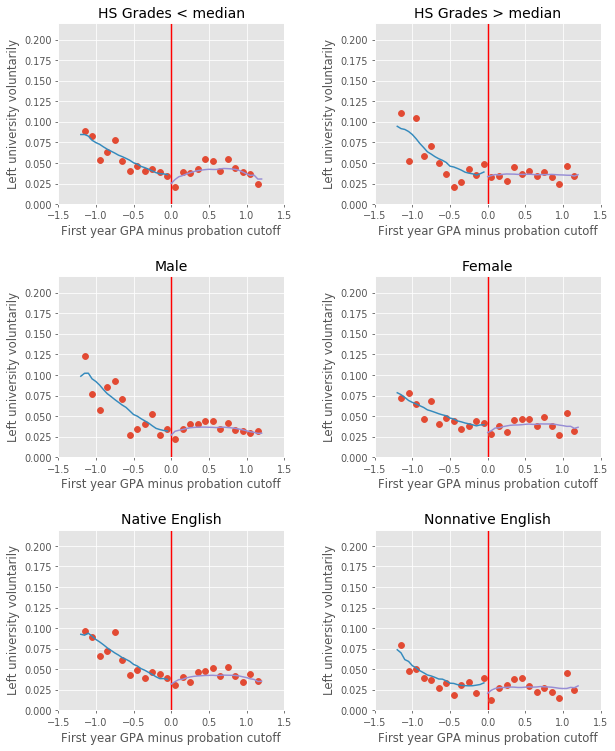

In [56]:
predictions_groups_dict_placebo1 = create_fig3_predictions(groups_dict = groups_dict_12_placebo1, 
                                                          regressors=regressors, 
                                                          bandwidth=0.6
                                                         )

figure_3_placebo1 = plot_figure3(inputs_dict = groups_dict_12_placebo1,  outputs_dict=predictions_groups_dict_placebo1, keys=groups_dict_keys)
figure_3_placebo1

---

## Additional

In [57]:
# Define sets of variables of interest.
outcomes = ['left_school','gradin4','gradin5','gradin6', 'dist_from_cut','year2_dist_from_cut', 'nextGPA', 
            'probation_year1', 'probation_year2', 'probation_summer1','probation_summer2', 'probation_ever', 
            'suspended_year1','suspended_summer1', 'suspended_year2', 'suspended_summer2','suspended_ever']

strats = ['lowHS','highHS','male','female','english','noenglish']

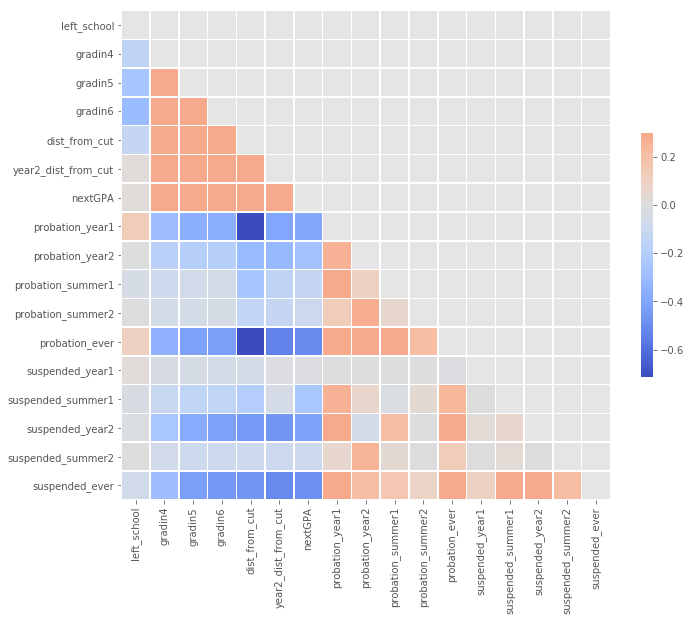

In [58]:
# Correlation heatmap of outcomes (some outcomes like graduation rates depend on other outcomes!)
corr = data[outcomes].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot figure
f, ax = plt.pyplot.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

C:\Users\arohanui\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


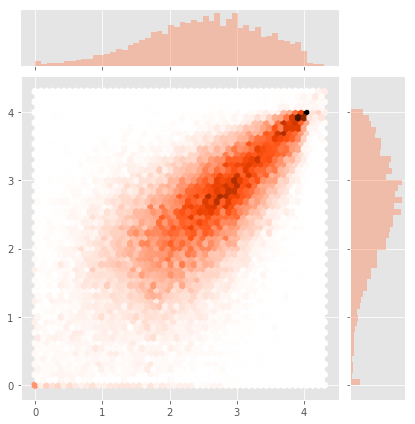

In [59]:
# GPA in year 1 and year 2
sns.jointplot(data[['GPA_year1']], data[['GPA_year2']], kind="hex", color="coral")

# Miscellaneous

This section will be removed for in the final notebook and is thus not relevant.

In [60]:
# Overview of all variables in dataset.
sample06[['credits1', 'credits2', 'credits_earned1', 'credits_earned2',
       'session1', 'winter_ac_standing', 'GPA_year1', 'GPA_year2',
       'CGPA_year1', 'CGPA_year2', 'totcredits_year1', 'totcredits_year2',
       'goodstanding_year1', 'goodstanding_year2', 'winter_ac_stand_year1',
       'winter_ac_stand_year2', ]].head()

,credits1,credits2,credits_earned1,credits_earned2,session1,winter_ac_standing,GPA_year1,GPA_year2,CGPA_year1,CGPA_year2,totcredits_year1,totcredits_year2,goodstanding_year1,goodstanding_year2,winter_ac_stand_year1,winter_ac_stand_year2
0,3.0,3.5,3.0,3.0,20009,OKAY,1.95,1.61,1.95,1.80,5.0,4.5,1,1,OKAY,OKAY
7,2.0,2.0,2.0,2.0,19969,OKAY,1.78,1.18,1.78,1.52,4.0,3.0,1,0,OKAY,PROB
14,2.5,2.5,2.5,2.5,20029,OKAY,1.94,2.14,1.94,2.09,5.0,5.0,1,1,OKAY,OKAY
16,2.0,2.5,2.0,2.0,19979,OKAY,2.10,1.53,2.10,1.80,4.0,4.5,1,1,OKAY,OKAY
18,3.0,0.0,2.5,0.0,20009,OKAY,1.78,NaN,1.78,NaN,4.5,0.0,1,0,OKAY,


In [61]:
sample06[['fallreg_year1', 'fallreg_year2',
       'act_fallreg_year1', 'act_fallreg_year2', 'summerreg_year1',
       'summerreg_year2', 'sex', 'mtongue', 'identifier', 'age_at_entry',
       'bpl_north_america', 'bpl_asia', 'canadian', 'bpl_other', 'firstyear',
       'yearstodegree', 'gradin4', 'gradin5', 'gradin6', 'gradin4orcont']].head()

,fallreg_year1,fallreg_year2,act_fallreg_year1,act_fallreg_year2,summerreg_year1,summerreg_year2,sex,mtongue,identifier,age_at_entry,bpl_north_america,bpl_asia,canadian,bpl_other,firstyear,yearstodegree,gradin4,gradin5,gradin6,gradin4orcont
0,1,1,REG,REG,1,1,M,English,10,18.0,1.0,0.0,1.0,0.0,2000,4.0,1.0,1.0,NaN,1.0
7,1,1,REG,REG,0,1,F,English,79,19.0,1.0,0.0,1.0,0.0,1996,5.0,0.0,1.0,1.0,1.0
14,1,1,REG,REG,1,1,F,English,178,19.0,1.0,0.0,1.0,0.0,2002,NaN,NaN,NaN,NaN,NaN
16,1,1,REG,REG,0,0,M,English,187,19.0,1.0,0.0,1.0,0.0,1997,NaN,0.0,0.0,0.0,1.0
18,1,0,REG,FINCA,1,0,M,English,202,19.0,1.0,0.0,1.0,0.0,2000,NaN,0.0,0.0,NaN,0.0


In [62]:
sample06[['cumcredits1', 'cumcredits2', 'prog_science', 'prog_socsci_bus',
       'prog_socscihum', 'prog_unknown', 'english', 'noenglish', 'french',
       'other_lang', 'female', 'male', 'gpacutoff', 'dist_from_cut',
       'year2_dist_from_cut', 'CGPA_final', 'nextGPA', 'nextCGPA', 'GPA_year1', 'GPA_year2']].head()
       

,cumcredits1,cumcredits2,prog_science,prog_socsci_bus,prog_socscihum,prog_unknown,english,noenglish,french,other_lang,female,male,gpacutoff,dist_from_cut,year2_dist_from_cut,CGPA_final,nextGPA,nextCGPA,GPA_year1,GPA_year2
0,3.0,6.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.5,0.45,0.11,2.37,0.50,0.45,1.95,1.61
7,2.0,4.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.6,0.18,-0.42,2.65,-0.42,-0.08,1.78,1.18
14,2.5,5.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.5,0.44,0.64,NaN,1.50,0.54,1.94,2.14
16,2.0,4.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.6,0.50,-0.07,NaN,-0.07,0.20,2.10,1.53
18,2.5,2.5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.6,0.18,NaN,NaN,0.40,0.22,1.78,NaN


In [63]:
sample06['suspended_year1'].value_counts()

0.0    12515
1.0       15
Name: suspended_year1, dtype: int64

In [64]:
sample06[['probation_year1', 'probation_year2', 'probation_summer1',
       'probation_summer2', 'probation_ever','suspended_year1','suspended_summer1', 
       'suspended_year2', 'suspended_summer2','suspended_ever', 'loc_campus1', 'loc_campus2', 'loc_campus3', 'all',
       'left_school']].head()

,probation_year1,probation_year2,probation_summer1,probation_summer2,probation_ever,suspended_year1,suspended_summer1,suspended_year2,suspended_summer2,suspended_ever,loc_campus1,loc_campus2,loc_campus3,all,left_school
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
18,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0


In [65]:
sample06[['gpalscutoff', 'gpaXgpalscutoff', 'gpaXgpagrcutoff',
          'gpasqXgpagrcutoff', 'dist_from_cut_med10', 'dist_from_cut_med05',
          'dist_from_cut_med025', 'hsgrade_pct', 'veryhighHS', 'highHS', 'lowHS',
          'maleXhighHS', 'femaleXhighHS', 'maleXlowabil', 'femaleXlowabil',
          'clustervar', 'summer']].head()

,gpalscutoff,gpaXgpalscutoff,gpaXgpagrcutoff,gpasqXgpagrcutoff,dist_from_cut_med10,dist_from_cut_med05,dist_from_cut_med025,hsgrade_pct,veryhighHS,highHS,lowHS,maleXhighHS,femaleXhighHS,maleXlowabil,femaleXlowabil,clustervar,summer
0,0.0,0.0,0.45,0.2025,0.45,0.475,0.4525,65,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.45,1.0
7,0.0,0.0,0.18,0.0324,0.15,0.175,0.1925,27,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.18,0.0
14,0.0,0.0,0.44,0.1936,0.45,0.425,0.4525,49,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.44,1.0
16,0.0,0.0,0.50,0.2500,0.55,0.525,0.5125,21,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.50,0.0
18,0.0,0.0,0.18,0.0324,0.15,0.175,0.1925,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.18,1.0


# References

Bénabou, R., & Tirole, J. (2000). Self-confidence and social interactions (No. w7585). National bureau of economic research.

Lee, D. S., & Lemieux, T. (2010). Regression discontinuity designs in economics. Journal of economic literature, 48(2), 281-355.

Lindo, J. M., Sanders, N. J., & Oreopoulos, P. (2010). Ability, gender, and performance standards: Evidence from academic probation. American Economic Journal: Applied Economics, 2(2), 95-117.
 